# Adaptive Large Neighborhood Search (ALNS) for Christmas Tree Packing Optimization

Adaptive Large Neighborhood Search (ALNS) is a metaheuristic optimization algorithm that extends the classic Large Neighborhood Search (LNS) framework by incorporating adaptive selection mechanisms for its operators.

Key Characteristics:
1. Destruction and Repair Framework: ALNS works by iteratively destroying part of a current solution and then repairing it to create a new solution
2. Adaptive Operator Selection: The algorithm dynamically adjusts which "destroy" and "repair" operators to use based on their historical performance
3. Acceptance Criterion: Uses simulated annealing or similar mechanisms to decide whether to accept worse solutions (to escape local optima)
4. Problem-Agnostic: Can be applied to various combinatorial optimization problems with appropriate operator design

Adaptive Large Neighborhood Search (ALNS) operates as a heuristic optimization method, meaning it does not guarantee mathematically optimal solutions. Instead, it seeks to find near optimal solutions that are often sufficient for practical applications. ALNS demonstrates particular strength in solving non-identical item arrangement and packing problems, where items vary in shape, size, orientation, or other attributes. This contrasts with identical-item packing problems that often have more straightforward optimal solutions

This code installs the Shapely geometry library and imports essential Python packages for mathematical computations, data handling, geometric operations, optimization algorithms, and visualization. These imports collectively enable the implementation and analysis of an ALNS algorithm for solving complex spatial arrangement problems like the Christmas tree packing problem.

In [1]:
!pip install shapely
import numpy as np
import pandas as pd
import random
import math
import time
from decimal import Decimal
from shapely import affinity
from shapely.geometry import Polygon
from shapely.strtree import STRtree
from sklearn.cluster import KMeans
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Defaulting to user installation because normal site-packages is not writeable


This code defines a ChristmasTree class that creates a geometric polygon representation of a Christmas tree with configurable position and rotation, using precise decimal coordinates and the Shapely library for spatial transformations.

In [79]:
# ===========================================================================================
# CHRISTMAS TREE CLASS (TANPA SCALE FACTOR)
# ===========================================================================================

class ChristmasTree:
    """Represents a single, rotatable Christmas tree"""
    
    # Counter unique id
    _id_counter = 0
    
    def __init__(self, center_x='0', center_y='0', angle='0', tree_id=None):
        # Assign unique id
        if tree_id is None:
            ChristmasTree._id_counter += 1
            self.id = ChristmasTree._id_counter
        else:
            self.id = tree_id
            
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)
        
        # Tree dimensions 
        trunk_w = 0.15
        trunk_h = 0.2
        base_w = 0.7
        mid_w = 0.4
        top_w = 0.25
        tip_y = 0.8
        tier_1_y = 0.5
        tier_2_y = 0.25
        base_y = 0.0
        trunk_bottom_y = -trunk_h
        
        
        initial_polygon = Polygon([
            (0.0, tip_y),
            (top_w / 2, tier_1_y),
            (top_w / 4, tier_1_y),
            (mid_w / 2, tier_2_y),
            (mid_w / 4, tier_2_y),
            (base_w / 2, base_y),
            (trunk_w / 2, base_y),
            (trunk_w / 2, trunk_bottom_y),
            (-(trunk_w / 2), trunk_bottom_y),
            (-(trunk_w / 2), base_y),
            (-(base_w / 2), base_y),
            (-(mid_w / 4), tier_2_y),
            (-(mid_w / 2), tier_2_y),
            (-(top_w / 4), tier_1_y),
            (-(top_w / 2), tier_1_y),
        ])
        
        # Rotation & translation
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated,
            xoff=float(self.center_x),
            yoff=float(self.center_y)
        )

This section contains the core helper functions for the ALNS algorithm: get_score() calculates packing density, has_overlap_fast() efficiently detects tree intersections, generate_initial_solution() creates starting arrangements, post_optimize_all_rotations() refines solutions with smart optimization techniques, and adaptive_weight_update() dynamically adjusts operator selection throughout the search process.

In [84]:
# ===========================================================================================
# HELPER FUNCTIONS
# ===========================================================================================
def get_score(trees):
    """Calculate score = s²/n where s is side of bounding box"""
    if not trees:
        return 0.0   
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    side = max(max_x - min_x, max_y - min_y)
    score = side ** 2 / len(trees)
    return float(score)

# ===========================================================================================
# OPTIMIZED OVERLAP CHECK
# ===========================================================================================

def has_overlap_fast(trees):
    """Fast overlap check"""
    if not trees:
        return False
    
    n = len(trees)
    

    if n <= 20:
        for i in range(n):
            for j in range(i + 1, n):
                if trees[i].polygon.intersects(trees[j].polygon):
                    if not trees[i].polygon.touches(trees[j].polygon):
                        return True
        return False
    

    polygons = [t.polygon for t in trees]
    tree_index = STRtree(polygons)
    
    for i, poly in enumerate(polygons):
        indices = tree_index.query(poly)
        for idx in indices:
            if idx == i:
                continue
            if poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                return True
    return False

def generate_initial_solution(n_trees):
    solution = []
    

    TREE_MAX_DIAGONAL = 1.3
    spacing = TREE_MAX_DIAGONAL * 0.95  
    
    grid_size = int(math.ceil(math.sqrt(n_trees)))
    
    for i in range(n_trees):
        row = i // grid_size
        col = i % grid_size
        x = col * spacing - (grid_size * spacing) / 2
        y = row * spacing - (grid_size * spacing) / 2
        
        #  Try BEST angle 
        best_angle = 0
        best_area = float('inf')
        
        for test_angle in [0, 45, 90, 135, 180, 225, 270, 315]:
            test_tree = ChristmasTree(str(x), str(y), str(test_angle))
            temp_sol = solution + [test_tree]
            
            # calculate bbox area
            xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in temp_sol])
            min_x, min_y = xys.min(axis=0)
            max_x, max_y = xys.max(axis=0)
            area = (max_x - min_x) * (max_y - min_y)
            
            if area < best_area and not has_overlap_fast(temp_sol):
                best_area = area
                best_angle = test_angle
        
        tree = ChristmasTree(str(x), str(y), str(best_angle))
        solution.append(tree)
    
    # Validation
    if has_overlap_fast(solution):
        print("Overlap detected, expanding slightly...")
        for tree in solution:
            tree.center_x *= Decimal('1.1')  
            tree.center_y *= Decimal('1.1')
            tree.__init__(str(tree.center_x), str(tree.center_y), str(tree.angle))
    
    print(f"Initial solution score: {get_score(solution):.6f}")
    return solution



def post_optimize_all_rotations(solution, max_iter=30):
    """
    SMART post-optimization:
    """
    print(f"   Optimizing {len(solution)} trees...")
    
    if not solution:
        return solution
    
    best_score = get_score(solution)
    initial_score = best_score
    
    #IMPROVEMENT 1: PRIORITIZE EDGE TREES 
    def get_tree_priority(tree_idx, solution):
        """Trees di edge = high priority (0), interior = low priority (1)"""
        tree = solution[tree_idx]
        xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in solution])
        min_x, min_y = xys.min(axis=0)
        max_x, max_y = xys.max(axis=0)
        
        tree_bounds = np.asarray(tree.polygon.exterior.xy).T
        tree_min_x, tree_min_y = tree_bounds.min(axis=0)
        tree_max_x, tree_max_y = tree_bounds.max(axis=0)
        
        eps = 0.01
        is_edge = (abs(tree_min_x - min_x) < eps or abs(tree_max_x - max_x) < eps or
                   abs(tree_min_y - min_y) < eps or abs(tree_max_y - max_y) < eps)
        
        return 0 if is_edge else 1
    
    # Sort trees by priority (edge first)
    tree_priorities = [(i, get_tree_priority(i, solution)) for i in range(len(solution))]
    tree_priorities.sort(key=lambda x: x[1])
    tree_order = [idx for idx, _ in tree_priorities]
    
    # IMPROVEMENT 2: ADAPTIVE ANGLES
    edge_angles = [0, 30, 45, 60, 90, 120, 135, 150, 180, 210, 225, 240, 270, 300, 315, 330]  
    interior_angles = [0, 45, 90, 135, 180, 225, 270, 315] 
    
    #IMPROVEMENT 3: BATCH TRACKING
    consecutive_no_improvement = 0
    batch_size = max(5, len(solution) // 10)  
    
    for iteration in range(max_iter):
        improved = False
        trees_improved_this_iter = 0
        
        #Use prioritized order
        for tree_idx in tree_order:
            original_x = solution[tree_idx].center_x
            original_y = solution[tree_idx].center_y
            original_angle = solution[tree_idx].angle
            
            temp_solution = solution[:tree_idx] + solution[tree_idx+1:]
            
            # ADAPTIVE: Use more angles for edge trees
            _, priority = tree_priorities[tree_idx]
            test_angles = edge_angles if priority == 0 else interior_angles
            
            best_angle = float(original_angle)
            best_test_score = best_score
            found_improvement = False
            
            # IMPROVEMENT 4: EARLY TERMINATION per tree
            for test_angle in test_angles:
                if test_angle == best_angle:  
                    continue
                
                new_tree = ChristmasTree(str(original_x), str(original_y), str(test_angle))
                test_solution = temp_solution + [new_tree]
                
                if not has_overlap_fast(test_solution):
                    test_score = get_score(test_solution)
                    
                    if test_score < best_test_score:
                        best_test_score = test_score
                        best_angle = test_angle
                        found_improvement = True
                        
                        # EARLY EXIT: Stop if excellent improvement
                        if test_score < best_score * 0.995:  # 0.5% improvement
                            break
            
            # Update improvement
            if best_test_score < best_score - 1e-9:
                new_tree = ChristmasTree(str(original_x), str(original_y), str(best_angle))
                solution[tree_idx] = new_tree
                best_score = best_test_score
                improved = True
                trees_improved_this_iter += 1
                consecutive_no_improvement = 0
            else:
                consecutive_no_improvement += 1
            
            # IMPROVEMENT 5: BATCH EARLY EXIT
            if consecutive_no_improvement >= batch_size:
                # No improvement in last N trees → skip rest of iteration
                break
        
        # Print progress every 5 iterations
        if (iteration + 1) % 5 == 0:
            improvement_pct = ((initial_score - best_score) / initial_score) * 100
            print(f"      Iter {iteration+1}: score={best_score:.6f} ({improvement_pct:.2f}% improved)")
        
        if not improved:
            print(f"   Converged after {iteration+1} iterations")
            break
    
    # Final summary
    total_improvement = initial_score - best_score
    improvement_pct = (total_improvement / initial_score) * 100
    print(f"   Total improvement: {total_improvement:.6f} ({improvement_pct:.2f}%)")
    
    return solution


# ===========================================================================================
# DYNAMIC ADAPTIVE MECHANISM - IMPROVED
# ===========================================================================================

def adaptive_weight_update(weights, selected_idx, code, iteration, max_iter, beta=0.8):
    """
    Update weight for chosen operator

    """
    progress = iteration / max_iter
    
    # Reward berdasarkan CODE
    if progress < 0.3:  # Exploration phase
        rewards = {
            1: 2.5,   # Better solution
            2: 1.5,   # Accepted
            3: 0.3,   # Rejected 
            4: 0.0    # Infeasible (no reward)
        }
    elif progress < 0.7:  # Balanced phase
        rewards = {
            1: 2.0,
            2: 1.2,
            3: 0.2,
            4: 0.0
        }
    else:  # Exploitation phase
        rewards = {
            1: 1.8,
            2: 1.0,
            3: 0.1,
            4: 0.0
        }
    
    reward = rewards[code]
    adaptive_beta = beta + (1 - beta) * progress
    

    for i in range(len(weights)):
        if i == selected_idx:  
            # get reward for chosen operator
            weights[i] = adaptive_beta * weights[i] + (1 - adaptive_beta) * reward
        else:
            # Operator lain: decay
            weights[i] = adaptive_beta * weights[i]
    
    # Normalization
    weights = np.maximum(weights, 0.01)
    weights = weights / weights.sum()
    
    # Diversity boost
    if weights.min() < 0.05:
        boost_factor = 0.05 * (1 - progress)
        weights += boost_factor
        weights = weights / weights.sum()
    
    return weights

This section implements the destroy and repair operators for the ALNS algorithm, with four destroy operators that efficiently remove trees using random destroy, spatial clustering, bounding box contribution analysis, and density-based sampling, and four repair operators that reconstruct solutions using random placement, greedy tessellation patterns, compact arrangement variants, and zone-based insertion strategies with strict angle preferences for optimal packing density.

In [85]:
# ===========================================================================================
# DESTROY OPERATORS
# ===========================================================================================

def destroy_random_fast(solution, rho):
    n = len(solution)
    k = max(1, int(n * rho))
    removed_idx = set(random.sample(range(n), min(k, n)))
    remaining = [solution[i] for i in range(n) if i not in removed_idx]
    removed = [solution[i] for i in removed_idx]
    return remaining, removed


def destroy_worst_bbox_contribution_fast(solution, rho):
    n = len(solution)
    k = max(1, int(n * rho))

    if n <= 5:
        return destroy_random_fast(solution, rho)

    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in solution])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)

    edge_idx = []
    eps = 1e-2
    for i, t in enumerate(solution):
        bounds = np.asarray(t.polygon.exterior.xy).T
        if (
            abs(bounds[:, 0].min() - min_x) < eps or
            abs(bounds[:, 0].max() - max_x) < eps or
            abs(bounds[:, 1].min() - min_y) < eps or
            abs(bounds[:, 1].max() - max_y) < eps
        ):
            edge_idx.append(i)

    if not edge_idx:
        return destroy_random_fast(solution, rho)

    k_edge = max(1, int(0.5 * k))
    k_rand = k - k_edge

    removed_idx = set(random.sample(edge_idx, min(k_edge, len(edge_idx))))
    interior_idx = [i for i in range(n) if i not in edge_idx]

    if interior_idx and k_rand > 0:
        removed_idx.update(random.sample(interior_idx, min(k_rand, len(interior_idx))))

    remaining = [solution[i] for i in range(n) if i not in removed_idx]
    removed = [solution[i] for i in removed_idx]
    return remaining, removed


def destroy_spatial_cluster_fast(solution, rho):
    n = len(solution)
    k = max(1, int(n * rho))

    if n <= 5:
        return destroy_random_fast(solution, rho)

    if n <= 20:
        sample_size = n
    elif n <= 50:
        sample_size = max(10, int(0.15 * n))
    else:
        sample_size = max(20, int(0.08 * n))

    sampled_idx = random.sample(range(n), sample_size)
    coords = np.array([[float(t.center_x), float(t.center_y)] for t in solution])
    sampled_coords = coords[sampled_idx]

    densities = []
    for i, idx in enumerate(sampled_idx):
        d = np.linalg.norm(coords - sampled_coords[i], axis=1)
        d = d[d > 0]
        avg = np.partition(d, min(3, len(d) - 1))[:min(3, len(d) - 1)].mean()
        densities.append((avg, idx))

    densities.sort(reverse=True)
    seed = densities[0][1] if densities else random.randrange(n)
    sx, sy = coords[seed]

    dists = [(np.hypot(cx - sx, cy - sy), i) for i, (cx, cy) in enumerate(coords)]
    dists.sort()

    k_near = int(0.6 * k)
    k_rand = k - k_near

    removed_idx = {i for _, i in dists[:k_near]}

    if k_rand > 0 and len(dists) > k_near + 5:
        mid = dists[k_near:k_near + 20]
        removed_idx.update(i for _, i in random.sample(mid, min(k_rand, len(mid))))

    remaining = [solution[i] for i in range(n) if i not in removed_idx]
    removed = [solution[i] for i in removed_idx]
    return remaining, removed


def destroy_worst_density(solution, rho):
    n = len(solution)
    k = max(1, int(n * rho))

    if n <= 3:
        return destroy_random_fast(solution, rho)

    coords = np.array([[float(t.center_x), float(t.center_y)] for t in solution])
    densities = []

    for i in range(n):
        d = np.linalg.norm(coords - coords[i], axis=1)
        d[i] = np.inf
        avg = np.partition(d, min(3, n - 1))[:min(3, n - 1)].mean()
        densities.append((1.0 / (avg + 0.01), i))

    densities.sort()
    removed_idx = {i for _, i in densities[:k]}

    remaining = [solution[i] for i in range(n) if i not in removed_idx]
    removed = [solution[i] for i in removed_idx]
    return remaining, removed


# ===========================================================================================
# REPAIR OPERATORS
# ===========================================================================================

def repair_random_fast(partial_solution, removed_trees):
    solution = partial_solution.copy()

    if not solution:
        g = int(math.ceil(math.sqrt(len(removed_trees))))
        s = 0.85
        for i in range(len(removed_trees)):
            x = (i % g) * s - (g * s) / 2
            y = (i // g) * s - (g * s) / 2
            solution.append(ChristmasTree(str(x), str(y), '0'))
        return solution

    cx = sum(float(t.center_x) for t in solution) / len(solution)
    cy = sum(float(t.center_y) for t in solution) / len(solution)

    coords = np.array([[float(t.center_x), float(t.center_y)] for t in solution])
    d = np.linalg.norm(coords - [cx, cy], axis=1)

    avg_r = d.mean()
    max_r = d.max()

    zones = [
        (0.0, 0.45 * avg_r, 12),
        (0.45 * avg_r, 0.9 * avg_r, 8),
        (0.9 * avg_r, 1.3 * max_r, 6)
    ]

    angles = [0, 90, 180, 270]

    for _ in removed_trees:
        for r_min, r_max, tries in zones:
            for _ in range(tries):
                r = random.uniform(r_min, r_max)
                a = random.uniform(0, 2 * math.pi)
                x, y = cx + r * math.cos(a), cy + r * math.sin(a)
                t = ChristmasTree(str(x), str(y), str(random.choice(angles)))
                if not has_overlap_fast(solution + [t]):
                    solution.append(t)
                    break
            else:
                continue
            break

    return solution

The run_alns() function implements the complete Adaptive Large Neighborhood Search algorithm with simulated annealing that iteratively applies destroy and repair operators, adaptively adjusts operator weights based on performance, and includes post-optimization refinement to solve the Christmas tree packing problem within specified time limits.

In [90]:
def run_alns(n_trees, random_seed=None, max_time_minutes=2.0):
    """
    ALNS with:
    1. Reduced computational cost
    2. Dynamic adaptive mechanism
    3. Time-based termination
    """
    
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
    
    print(f"\n{'='*80}")
    print(f"ALNS OPTIMIZED v2.0 - Christmas Tree Packing (n={n_trees})")
    print(f"{'='*80}")
    
    #OPTIMIZED PARAMETERS
    T_init = 100000
    T_final = 0.01
    alpha = 0.97
    DoD = [0.2, 0.4]
    max_iter_estimate = int(math.log(T_final / T_init) / math.log(alpha))
    
    print(f"\n Optimized Parameters v2:")
    print(f"   T_init: {T_init}, T_final: {T_final}, alpha: {alpha}")
    print(f"   Estimated max iterations: {max_iter_estimate}") 
    print(f"   DoD: {DoD}, Time limit: {max_time_minutes}min")
    
    # Generate initial solution
    current_solution = generate_initial_solution(n_trees)
    current_score = get_score(current_solution)
    best_solution = current_solution.copy()
    best_score = current_score
    
    print(f"Initial score: {current_score:.6f}")
    
    # Operators - FAST VERSION
    destroy_ops = [
        destroy_random_fast,
        destroy_worst_bbox_contribution_fast,
        destroy_spatial_cluster_fast,
        destroy_worst_density
    ]
    
    repair_ops = [
        repair_random_fast,
        repair_greedy_fast, 
        repair_compact_smart,
        repair_zone_insertion
    ]
    
    # Weights
    Destroy_Weight = np.ones(4) / 4
    Repair_Weight = np.ones(4) / 4
    
    # Statistics
    n_accepted = 0
    n_better = 0
    n_iterations = 0
    T = T_init
    
    start_time = time.time()
    max_time_seconds = max_time_minutes * 60
    
    # Header
    print(f"\n{'Iter':<6} {'T':<10} {'Current':<10} {'Best':<10} {'Time(s)':<8} | "
          f"{'D1':<6} {'D2':<6} {'D3':<6} {'D4':<6} | "
          f"{'R1':<6} {'R2':<6} {'R3':<6} {'R4':<6}")
    print("-" * 100)
    
    while T > T_final and (time.time() - start_time) < max_time_seconds:
        temp_progress = (T_init - T) / (T_init - T_final)
        rho = DoD[1] - (DoD[1] - DoD[0]) * temp_progress
        
        #DETERMINE PHASE
        if temp_progress < 0.3:
            phase = 'explore'
        elif temp_progress < 0.7:
            phase = 'balanced'
        else:
            phase = 'exploit'
        
        # Select operators
        destroy_probs = Destroy_Weight / Destroy_Weight.sum()
        destroy_idx = np.random.choice(4, p=destroy_probs)
        
        repair_probs = Repair_Weight / Repair_Weight.sum()
        repair_idx = np.random.choice(4, p=repair_probs)
        
        # Apply destroy
        partial_solution, removed_trees = destroy_ops[destroy_idx](current_solution, rho)
        
        #Apply repair WITH PHASE for greedy
        if repair_idx == 1:  # repair_greedy_fast
            new_solution = repair_greedy_fast(partial_solution, removed_trees, phase)
        else:
            new_solution = repair_ops[repair_idx](partial_solution, removed_trees)

        #EVALUATE WITH VALIDATION (INSIDE WHILE LOOP - 8 SPACES!)
        if len(new_solution) != n_trees:
            code = 4
            new_score = float('inf')
        elif has_overlap_fast(new_solution):
            code = 4
            new_score = float('inf')
        else:
            new_score = get_score(new_solution)
            delta = new_score - current_score

            if delta < -1e-9:
                current_solution = new_solution
                current_score = new_score
                code = 1
                n_accepted += 1
                n_better += 1

                if new_score < best_score - 1e-9:
                    best_solution = new_solution.copy()
                    best_score = new_score
            elif random.random() < math.exp(-delta / T):
                current_solution = new_solution
                current_score = new_score
                code = 2
                n_accepted += 1
            else:
                code = 3
        
        Destroy_Weight = adaptive_weight_update(
            Destroy_Weight, 
            destroy_idx,  
            code,         
            n_iterations, 
            max_iter_estimate
        )

        Repair_Weight = adaptive_weight_update(
            Repair_Weight, 
            repair_idx,  
            code,         
            n_iterations, 
            max_iter_estimate
        )
        n_iterations += 1
        T *= alpha
        
        # Print progress
        if n_iterations % 10 == 0:
            elapsed = time.time() - start_time
            print(f"{n_iterations:<6} {T:<10.1e} {current_score:<10.4f} {best_score:<10.4f} {elapsed:<8.1f} | "
                  f"{Destroy_Weight[0]:<6.2f} {Destroy_Weight[1]:<6.2f} {Destroy_Weight[2]:<6.2f} {Destroy_Weight[3]:<6.2f} | "
                  f"{Repair_Weight[0]:<6.2f} {Repair_Weight[1]:<6.2f} {Repair_Weight[2]:<6.2f} {Repair_Weight[3]:<6.2f}")
    
    elapsed = time.time() - start_time
    
    print(f"\n{'='*80}")
    print(f" COMPLETED in {elapsed:.2f}s ({n_iterations} iterations)")
    print(f"   Acceptance rate: {(n_accepted/n_iterations)*100:.1f}%")
    print(f"   Better solutions: {n_better}")
    
    # Post-optimization
    print(f"\n Post-optimizing...")
    best_solution = post_optimize_all_rotations(best_solution, max_iter=30)
    best_score = get_score(best_solution)
    
    print(f"\n{'='*60}")
    print(f"AFTER POST-OPTIMIZATION:")
    print(f"   Trees: {len(best_solution)}")
    print(f"   Score: {best_score:.6f}")
    print(f"   Has overlap: {has_overlap_fast(best_solution)}")
    for i, t in enumerate(best_solution):
        print(f"   Tree {i}: x={float(t.center_x):.3f}, y={float(t.center_y):.3f}, angle={t.angle}")
    print(f"{'='*60}\n")
    
    print(f"After optimization: {best_score:.6f}")
    print(f"{'='*80}")
    
    return best_solution, best_score, {'time': elapsed, 'iterations': n_iterations}

The load_solution() function reads and parses Christmas tree arrangements from CSV files, while plot_alns_results() and plot_alns_comparison() create visualizations of tree placements and bounding boxes; the main execution section then loads existing solutions, runs the ALNS algorithm for specified tree counts, displays performance summaries, and optionally generates comparison plots showing initial versus optimized arrangements.


CHRISTMAS TREE PACKING ALNS
Running for n = [10]

 Loading CSV file...
 Loaded 200 different n values from sample_submission.csv

 Running ALNS for n = [10]


################################################################################
SOLVING FOR n = 10 TREES
################################################################################

Initial solution score: 2.135073

ALNS OPTIMIZED v2.0 - Christmas Tree Packing (n=10)

 Optimized Parameters v2:
   T_init: 100000, T_final: 0.01, alpha: 0.97
   Estimated max iterations: 529
   DoD: [0.2, 0.4], Time limit: 2.0min
Initial solution score: 2.135073
Initial score: 2.135073

Iter   T          Current    Best       Time(s)  | D1     D2     D3     D4     | R1     R2     R3     R4    
----------------------------------------------------------------------------------------------------
10     7.4e+04    1.0414     1.0414     4.6      | 0.57   0.25   0.11   0.07   | 0.07   0.12   0.07   0.73  
20     5.4e+04    1.0514     1.0414     7.2 

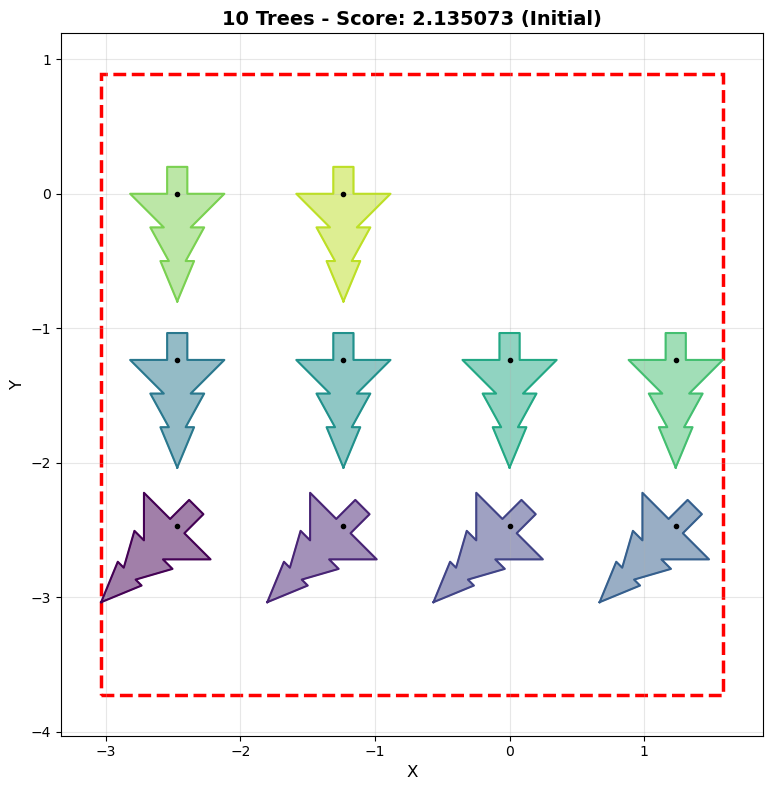

   → Final solution


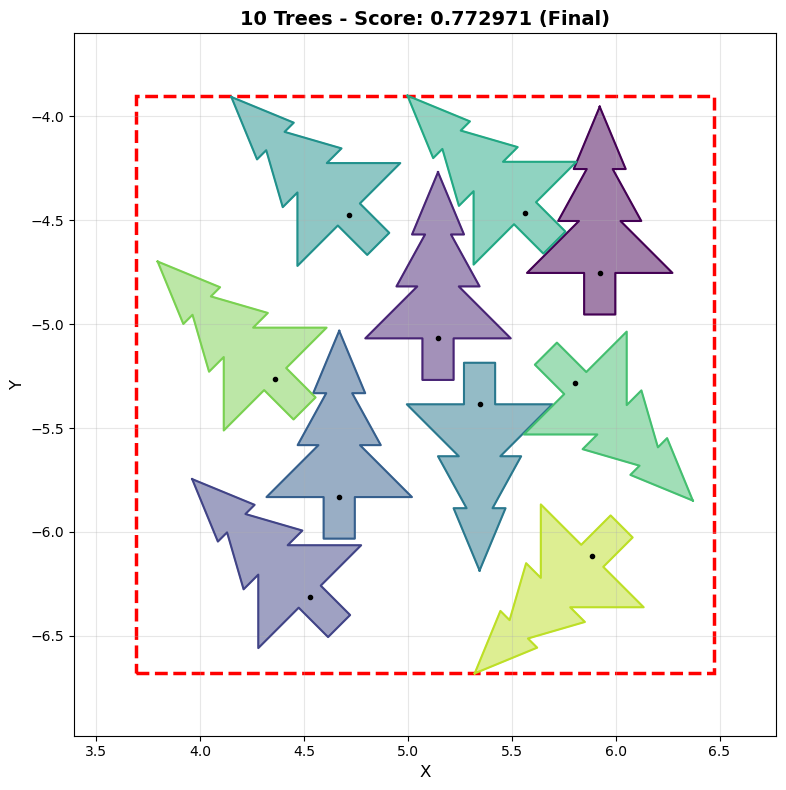

   → Comparison


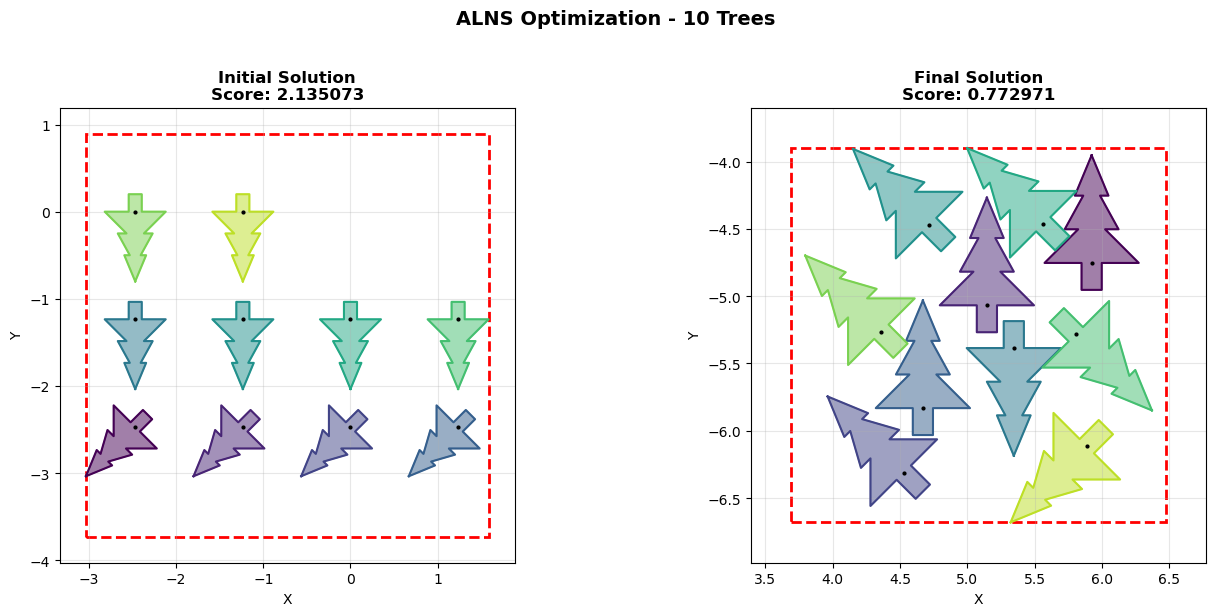


 All visualizations complete!



In [91]:
# ===========================================================================================
# LOAD SOLUTION FROM CSV 
# ===========================================================================================
def load_solution(filename):
    df = pd.read_csv(filename)
    
    trees_by_n = {}
    
    for _, row in df.iterrows():
        # Parse id: "003_1" -> n=3, index=1
        n_str, idx_str = row['id'].split('_')
        n = int(n_str)
        
        # Parse coordinates: "s0.202736" -> "0.202736"
        x = row['x'].replace('s', '')
        y = row['y'].replace('s', '')
        deg = row['deg'].replace('s', '')
        
        if n not in trees_by_n:
            trees_by_n[n] = []
        
        tree = ChristmasTree(x, y, deg)
        trees_by_n[n].append(tree)
    
    print(f" Loaded {len(trees_by_n)} different n values from {filename}")
    return trees_by_n


# ===========================================================================================
# VISUALIZATION FUNCTIONS
# ===========================================================================================

def plot_alns_results(solution, n_trees, title_suffix=""):
    """
    Plot arrangement of Christmas trees with bounding box
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Generate colors for each tree
    colors = plt.cm.viridis([i / n_trees for i in range(n_trees)])
    
    # Get all coordinates for bounding box calculation
    all_coords = []
    for tree in solution:
        coords = np.asarray(tree.polygon.exterior.xy).T
        all_coords.append(coords)
    
    all_coords = np.vstack(all_coords)
    min_x, min_y = all_coords.min(axis=0)
    max_x, max_y = all_coords.max(axis=0)
    
    # Calculate bounding box side (square)
    side_length = max(max_x - min_x, max_y - min_y)
    
    # Plot each tree
    for i, tree in enumerate(solution):
        x, y = tree.polygon.exterior.xy
        ax.plot(x, y, color=colors[i], linewidth=1.5)
        ax.fill(x, y, alpha=0.5, color=colors[i])
        
        # Add tree center marker
        cx, cy = float(tree.center_x), float(tree.center_y)
        ax.plot(cx, cy, 'ko', markersize=3)
    
    # Draw bounding square (centered)
    if max_x - min_x >= max_y - min_y:
        square_x = min_x
        square_y = min_y - (side_length - (max_y - min_y)) / 2
    else:
        square_x = min_x - (side_length - (max_x - min_x)) / 2
        square_y = min_y
    
    bounding_square = Rectangle(
        (square_x, square_y),
        side_length,
        side_length,
        fill=False,
        edgecolor='red',
        linewidth=2.5,
        linestyle='--',
        label='Bounding Box'
    )
    ax.add_patch(bounding_square)
    
    # Set axis limits with padding
    padding = 0.3
    ax.set_xlim(square_x - padding, square_x + side_length + padding)
    ax.set_ylim(square_y - padding, square_y + side_length + padding)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Calculate score
    score = side_length ** 2 / n_trees
    
    # Title and labels
    title = f'{n_trees} Trees - Score: {score:.6f}'
    if title_suffix:
        title += f' ({title_suffix})'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    plt.tight_layout()
    plt.show()


def plot_alns_comparison(initial_sol, final_sol, n_trees):
    """
    Plot side-by-side comparison of initial vs final solution
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    colors = plt.cm.viridis([i / n_trees for i in range(n_trees)])
    
    # Function to plot on given axis
    def plot_on_axis(ax, solution, title):
        # Get coordinates
        all_coords = np.vstack([np.asarray(t.polygon.exterior.xy).T for t in solution])
        min_x, min_y = all_coords.min(axis=0)
        max_x, max_y = all_coords.max(axis=0)
        side_length = max(max_x - min_x, max_y - min_y)
        
        # Plot trees
        for i, tree in enumerate(solution):
            x, y = tree.polygon.exterior.xy
            ax.plot(x, y, color=colors[i], linewidth=1.5)
            ax.fill(x, y, alpha=0.5, color=colors[i])
            ax.plot(float(tree.center_x), float(tree.center_y), 'ko', markersize=2)
        
        # Bounding square
        if max_x - min_x >= max_y - min_y:
            square_x, square_y = min_x, min_y - (side_length - (max_y - min_y)) / 2
        else:
            square_x, square_y = min_x - (side_length - (max_x - min_x)) / 2, min_y
        
        square = Rectangle(
            (square_x, square_y), side_length, side_length,
            fill=False, edgecolor='red', linewidth=2, linestyle='--'
        )
        ax.add_patch(square)
        
        padding = 0.3
        ax.set_xlim(square_x - padding, square_x + side_length + padding)
        ax.set_ylim(square_y - padding, square_y + side_length + padding)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)
        
        score = side_length ** 2 / n_trees
        ax.set_title(f'{title}\nScore: {score:.6f}', fontsize=12, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plot_on_axis(ax1, initial_sol, 'Initial Solution')
    plot_on_axis(ax2, final_sol, 'Final Solution')
    
    plt.suptitle(f'ALNS Optimization - {n_trees} Trees', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# ===========================================================================================
# MAIN EXECUTION - STREAMLINED
# ===========================================================================================
if __name__ == "__main__":
    # ========== CONFIGURATION ==========
    INPUT_FILE = 'sample_submission.csv'
    
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    RUN_N_ONLY = [10]   
    
    SHOW_PLOTS = True      
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    print(f"\n{'='*80}")
    print(f"CHRISTMAS TREE PACKING ALNS")
    print(f"Running for n = {RUN_N_ONLY}")
    print(f"{'='*80}")
    
    # Load existing solution
    print("\n Loading CSV file...")
    all_solutions = load_solution(INPUT_FILE)
    
    # Validate n values
    available_n = sorted(all_solutions.keys())
    n_values = [n for n in RUN_N_ONLY if n in available_n]
    
    if len(n_values) == 0:
        raise ValueError(f" No valid n values. Available: {available_n}")
    
    if len(n_values) < len(RUN_N_ONLY):
        missing = set(RUN_N_ONLY) - set(n_values)
        print(f"  Skipping unavailable n values: {missing}")
    
    print(f"\n Running ALNS for n = {n_values}\n")
    
    # ===========================================================================================
    # RUN ALNS FOR EACH N
    # ===========================================================================================
    results = {}
    
    for n in n_values:
        print(f"\n{'#'*80}")
        print(f"SOLVING FOR n = {n} TREES")
        print(f"{'#'*80}\n")
        
        # Generate initial solution
        initial_solution = generate_initial_solution(n)
        initial_score = get_score(initial_solution)
        
        # Run ALNS
        solution, score, params = run_alns(
            n_trees=n,
            random_seed=42
        )
        
        # Calculate improvement
        improvement_pct = ((initial_score - score) / initial_score * 100)
        
        # Store results
        results[n] = {
            'initial_solution': initial_solution,
            'initial_score': initial_score,
            'final_solution': solution,
            'final_score': score,
            'improvement_pct': improvement_pct,
            'time': params['time'],
            'iterations': params['iterations']
        }
    
    # ===========================================================================================
    # SUMMARY TABLE
    # ===========================================================================================
    print(f"\n\n{'='*80}")
    print(f"OPTIMIZATION SUMMARY")
    print(f"{'='*80}")
    print(f"\n{'N':<6} {'Initial':<12} {'Final':<12} {'Improve %':<12} {'Time(s)':<10} {'Iters':<8}")
    print("-" * 70)
    
    for n in n_values: 
        res = results[n]
        print(f"{n:<6} {res['initial_score']:<12.6f} {res['final_score']:<12.6f} "
              f"{res['improvement_pct']:<12.2f} {res['time']:<10.1f} {res['iterations']:<8}")
    
    total_initial = sum(results[n]['initial_score'] for n in n_values)
    total_final = sum(results[n]['final_score'] for n in n_values)
    total_improve = ((total_initial - total_final) / total_initial * 100)
    
    print("-" * 70)
    print(f"{'TOTAL':<6} {total_initial:<12.6f} {total_final:<12.6f} {total_improve:<12.2f}")
    print(f"{'='*80}\n")
    
    # ===========================================================================================
    # VISUALIZATION
    # ===========================================================================================
    if SHOW_PLOTS:
        print(f"{'='*80}")
        print(f"VISUALIZATION")
        print(f"{'='*80}\n")
        
        for n in n_values: 
            res = results[n]
            
            print(f" Visualizing n = {n}...")
            
            # Plot 1: Initial solution
            print(f"   → Initial solution")
            plot_alns_results(res['initial_solution'], n, "Initial")
            
            # Plot 2: Final solution
            print(f"   → Final solution")
            plot_alns_results(res['final_solution'], n, "Final")
            
            # Plot 3: Side-by-side comparison
            print(f"   → Comparison")
            plot_alns_comparison(res['initial_solution'], res['final_solution'], n)
            
            print()
        
        print(f"{'='*80}")
        print(f" All visualizations complete!")
        print(f"{'='*80}\n")
    else:
        print("  Visualization skipped (SHOW_PLOTS = False)\n")

This main execution script performs batch optimization by running the ALNS algorithm and post-optimization process for multiple tree counts (1-200 trees), calculates cumulative scores and performance statistics, and displays progress updates throughout the execution while validating solutions for overlaps and measuring computation times.

In [92]:
# ===========================================================================================
# MAIN EXECUTION - WITH POST-OPTIMIZATION FOR ALL N
# ===========================================================================================
if __name__ == "__main__":
    # ========== FILE CONFIGURATION ==========
    INPUT_FILE = 'sample_submission.csv'
    
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # RUN ALL
    RUN_N_ONLY = list(range(1, 201)) 
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    # ========== POST-OPTIMIZATION SETTINGS ==========
    POST_OPT_MAX_ITER = 30  
    
    print(f"\n{'='*80}")
    print(f"CHRISTMAS TREE PACKING ALNS")
    print(f"Running for n = ALL 1-200")
    print(f"{'='*80}")
    
    # Load existing solution (ONCE)
    print("\n Loading CSV file...")
    all_solutions = load_solution(INPUT_FILE)
    
    # Validasi & filter n
    available_n = sorted(all_solutions.keys())
    n_values = [n for n in RUN_N_ONLY if n in available_n]
    
    print(f"\n Loaded {len(n_values)} groups: from n={min(n_values)} to n={max(n_values)}")
    print(f"   Post-optimization enabled for ALL n (max {POST_OPT_MAX_ITER} iterations)")
    
    if len(n_values) == 0:
        raise ValueError(f". Available n: {available_n}")
    
    print(f"\n Running ALNS for ALL {len(n_values)} groups")
    print(f"   Estimated time: ~{len(n_values)*2.5} minutes")
    
    # Run ALNS untuk SEMUA n
    results = {}
    scores_per_n = {}
    post_opt_improvements = {} 
    total_start_time = time.time()
    
    for i, n in enumerate(n_values, 1):
        print(f"\n\n{'#'*80}")
        print(f"SOLVING {i}/{len(n_values)}: n = {n} TREES")
        print(f"{'#'*80}")
        
        # ===== RUN ALNS =====
        solution, score, params = run_alns(
            n_trees=n,
            random_seed=42
        )
        
        initial_score = score
        alns_time = params['time']
        alns_iters = params['iterations']
        
        # ===== POST-OPTIMIZATION =====
        print(f"\n Post-optimizing...")
        post_opt_start = time.time()
        
        solution = post_optimize_all_rotations(solution, max_iter=POST_OPT_MAX_ITER)
        score = get_score(solution)
        
        post_opt_time = time.time() - post_opt_start
        improvement = initial_score - score
        improvement_pct = (improvement / initial_score) * 100 if initial_score > 0 else 0
        
        print(f"   Before post-opt: {initial_score:.6f}")
        print(f"   After post-opt:  {score:.6f}")
        print(f"   Improvement: {improvement:.6f} ({improvement_pct:.2f}%)")
        print(f"   Post-opt time: {post_opt_time:.1f}s")
        
        post_opt_improvements[n] = {
            'before': initial_score,
            'after': score,
            'improvement': improvement,
            'improvement_pct': improvement_pct,
            'time': post_opt_time
        }
        
        # ===== VALIDATION =====
        if has_overlap_fast(solution):
            print(f" WARNING: Overlap detected after post-optimization!")
        
        # Store results
        results[n] = (solution, score, {
            'alns_time': alns_time,
            'alns_iterations': alns_iters,
            'post_opt_time': post_opt_time,
            'total_time': alns_time + post_opt_time
        })
        scores_per_n[n] = score
        
        # Progress report
        elapsed = time.time() - total_start_time
        avg_time = elapsed / i
        remaining = avg_time * (len(n_values) - i)
        
        current_total_score = sum(scores_per_n.values())
        
        print(f"\n Progress: {i}/{len(n_values)} ({i/len(n_values)*100:.1f}%)")
        print(f"   Time elapsed: {elapsed/60:.1f}m, Remaining: ~{remaining/60:.1f}m")
        print(f"   Current total score: {current_total_score:.6f}")
        print(f"   Score for n={n}: {score:.6f}")
    
    # ======================== FINAL CALCULATION ========================
    total_score = sum(score for n, (_, score, _) in results.items())
    total_elapsed = time.time() - total_start_time
    
    print(f"\n{'='*80}")
    print(f" COMPLETED ALL {len(results)} GROUPS!")
    print(f"{'='*80}")
    
    # ======================== SCORE SUMMARY ========================
    print(f"\n SCORE SUMMARY:")
    print(f"{'-'*50}")
    print(f"Total score (sum of all S²/N): {total_score:.6f}")
    print(f"Number of groups optimized:    {len(results)}")
    print(f"Total time:                    {total_elapsed/60:.1f} minutes")
    print(f"Average time per group:        {total_elapsed/len(results):.1f} seconds")
    print(f"{'-'*50}")
    
    
    # ======================== STATISTICS ========================
    scores_list = [score for _, score, _ in results.values()]
    print(f"\n STATISTICS:")
    print(f"   Minimum score: {min(scores_list):.6f}")
    print(f"   Maximum score: {max(scores_list):.6f}")
    print(f"   Average score: {np.mean(scores_list):.6f}")
    print(f"   Median score:  {np.median(scores_list):.6f}")
    
    print(f"\n{'='*80}")
    print(f" OPTIMIZATION FINISHED!")
    print(f"   FINAL TOTAL SCORE: {total_score:.6f}")
    print(f"{'='*80}")


CHRISTMAS TREE PACKING ALNS
Running for n = ALL 1-200

 Loading CSV file...
 Loaded 200 different n values from sample_submission.csv

 Loaded 200 groups: from n=1 to n=200
   Post-optimization enabled for ALL n (max 30 iterations)

 Running ALNS for ALL 200 groups
   Estimated time: ~500.0 minutes


################################################################################
SOLVING 1/200: n = 1 TREES
################################################################################

ALNS OPTIMIZED v2.0 - Christmas Tree Packing (n=1)

 Optimized Parameters v2:
   T_init: 100000, T_final: 0.01, alpha: 0.97
   Estimated max iterations: 529
   DoD: [0.2, 0.4], Time limit: 2.0min
Initial solution score: 0.661250
Initial score: 0.661250

Iter   T          Current    Best       Time(s)  | D1     D2     D3     D4     | R1     R2     R3     R4    
----------------------------------------------------------------------------------------------------
10     7.4e+04    1.0000     0.6612     0.0

For future work, algorithmic modifications are required to reduce the spacing between trees and to ensure that, for large values of n, the central area of the solution is filled with trees rather than remaining empty.